# Pengerjaan Tugas UTS Deep Learning menggunakan TensorFlow (Klasifikasi Ikan)

# Persiapan: Instalasi library

In [1]:
%pip install numpy pandas matplotlib scikit-learn tensorflow


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Deep Learning dengan TensorFlow (CNN)

## A. Tahapan Persiapan dan Data Preprocessing

### 1. Import Library yang Diperlukan

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D, GaussianNoise, ActivityRegularization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import warnings

warnings.filterwarnings('ignore')

2025-05-01 12:35:41.492464: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 12:35:41.552081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746077741.587334  117573 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746077741.601657  117573 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746077741.644089  117573 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### 2. Memuat Dataset Klasifikasi Ikan

Memeriksa dataset...


I0000 00:00:1746077744.251196  117573 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


File tidak valid: FishImgDataset/train/Silver Perch/silver perch (1).webp
File tidak valid: FishImgDataset/train/Silver Perch/silver perch (4).webp


2025-05-01 12:35:49.953876: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
2025-05-01 12:35:50.002682: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.


Direktori: FishImgDataset/train
Jumlah gambar valid: 8819
Jumlah gambar tidak valid: 2
Jenis ikan: ['Goby', 'Snakehead', 'Jaguar Gapote', 'Indian Carp', 'Climbing Perch', 'Indo-Pacific Tarpon', 'Catfish', 'Long-Snouted Pipefish', 'Tilapia', 'Mullet', 'Bangus', 'Pangasius', 'Gold Fish', 'Fourfinger Threadfin', 'Perch', 'Knifefish', 'Green Spotted Puffer', 'Silver Barb', 'Glass Perchlet', 'Janitor Fish', 'Black Spotted Barb', 'Silver Perch', 'Scat Fish', 'Mudfish', 'Grass Carp', 'Freshwater Eel', 'Silver Carp', 'Gourami', 'Tenpounder', 'Big Head Carp', 'Mosquito Fish']
--------------------------------------------------
Direktori: FishImgDataset/val
Jumlah gambar valid: 2751
Jumlah gambar tidak valid: 0
Jenis ikan: ['Goby', 'Snakehead', 'Jaguar Gapote', 'Indian Carp', 'Climbing Perch', 'Indo-Pacific Tarpon', 'Catfish', 'Long-Snouted Pipefish', 'Tilapia', 'Mullet', 'Bangus', 'Pangasius', 'Gold Fish', 'Fourfinger Threadfin', 'Perch', 'Knifefish', 'Green Spotted Puffer', 'Silver Barb', 'Glas

<Figure size 1400x800 with 0 Axes>

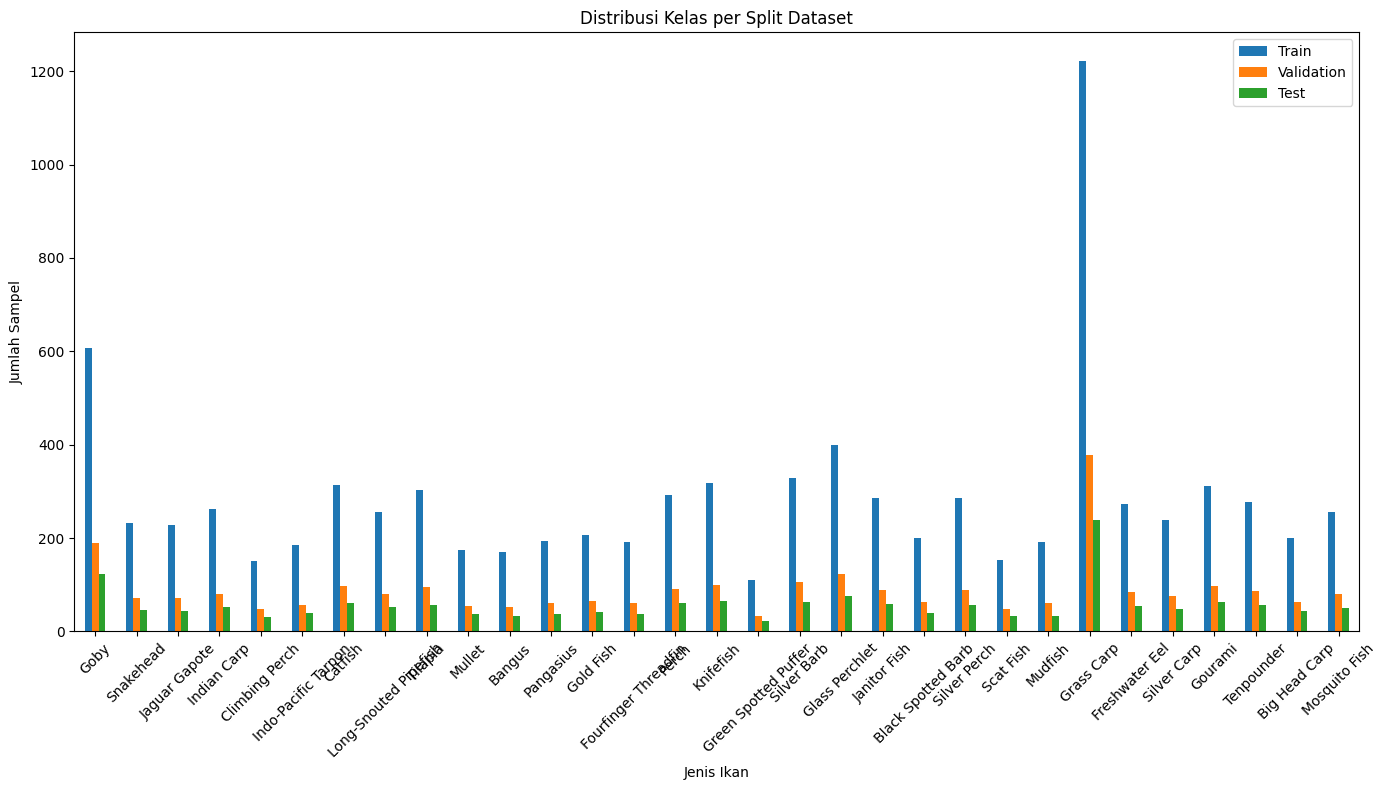

In [3]:
# Tentukan path dataset
dataset_path = 'FishImgDataset'
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')

# Fungsi untuk memeriksa keberadaan dan validitas gambar
def check_image_validity(directory):
    valid_images = 0
    invalid_images = 0
    fish_types = []
    
    for fish_type in os.listdir(directory):
        fish_dir = os.path.join(directory, fish_type)
        if os.path.isdir(fish_dir):
            fish_types.append(fish_type)
            for image_file in os.listdir(fish_dir):
                image_path = os.path.join(fish_dir, image_file)
                try:
                    img = tf.io.decode_image(tf.io.read_file(image_path))
                    valid_images += 1
                except:
                    invalid_images += 1
                    print(f"File tidak valid: {image_path}")
    
    print(f"Direktori: {directory}")
    print(f"Jumlah gambar valid: {valid_images}")
    print(f"Jumlah gambar tidak valid: {invalid_images}")
    print(f"Jenis ikan: {fish_types}")
    print("-" * 50)
    
    return fish_types

# Memeriksa validitas dataset
print("Memeriksa dataset...")
train_fish_types = check_image_validity(train_path)
val_fish_types = check_image_validity(val_path)
test_fish_types = check_image_validity(test_path)

# Membuat DataFrame untuk menghitung jumlah sampel per kelas
def get_class_distribution(directory, fish_types):
    distribution = {}
    for fish_type in fish_types:
        fish_dir = os.path.join(directory, fish_type)
        if os.path.isdir(fish_dir):
            count = len(os.listdir(fish_dir))
            distribution[fish_type] = count
    return distribution

train_distribution = get_class_distribution(train_path, train_fish_types)
val_distribution = get_class_distribution(val_path, val_fish_types)
test_distribution = get_class_distribution(test_path, test_fish_types)

# Membuat DataFrame untuk visualisasi distribusi kelas
df_distribution = pd.DataFrame({
    'Train': train_distribution,
    'Validation': val_distribution,
    'Test': test_distribution
})

print("Distribusi kelas per split dataset:")
print(df_distribution)

# Visualisasi distribusi kelas
plt.figure(figsize=(14, 8))
df_distribution.plot(kind='bar', figsize=(14, 8))
plt.title('Distribusi Kelas per Split Dataset')
plt.xlabel('Jenis Ikan')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fish_class_distribution.png')
plt.show()

# Viisualisasi 

### 3. Menyiapkan Fungsi Preprocessing

In [ ]:
# Konstanta untuk preprocessing
IMG_SIZE = 84  # Ukuran standar untuk banyak arsitektur CNN
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,         
    width_shift_range=0.1,     
    height_shift_range=0.1,    
    shear_range=0.1,           
    zoom_range=0.1,            
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1.1],  
    channel_shift_range=10,       
    fill_mode='reflect'           
)

# Hanya rescaling untuk validation dan test data
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator untuk training, validation, dan test
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Simpan informasi kelas
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"Jumlah kelas: {num_classes}")
print(f"Nama kelas: {class_names}")
print(f"Mapping kelas: {class_indices}")


Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.
Jumlah kelas: 31
Nama kelas: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']
Mapping kelas: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 1

### 4. Menampilkan Augmentasi dan Feature Engineering

Visualisasi augmentasi data...


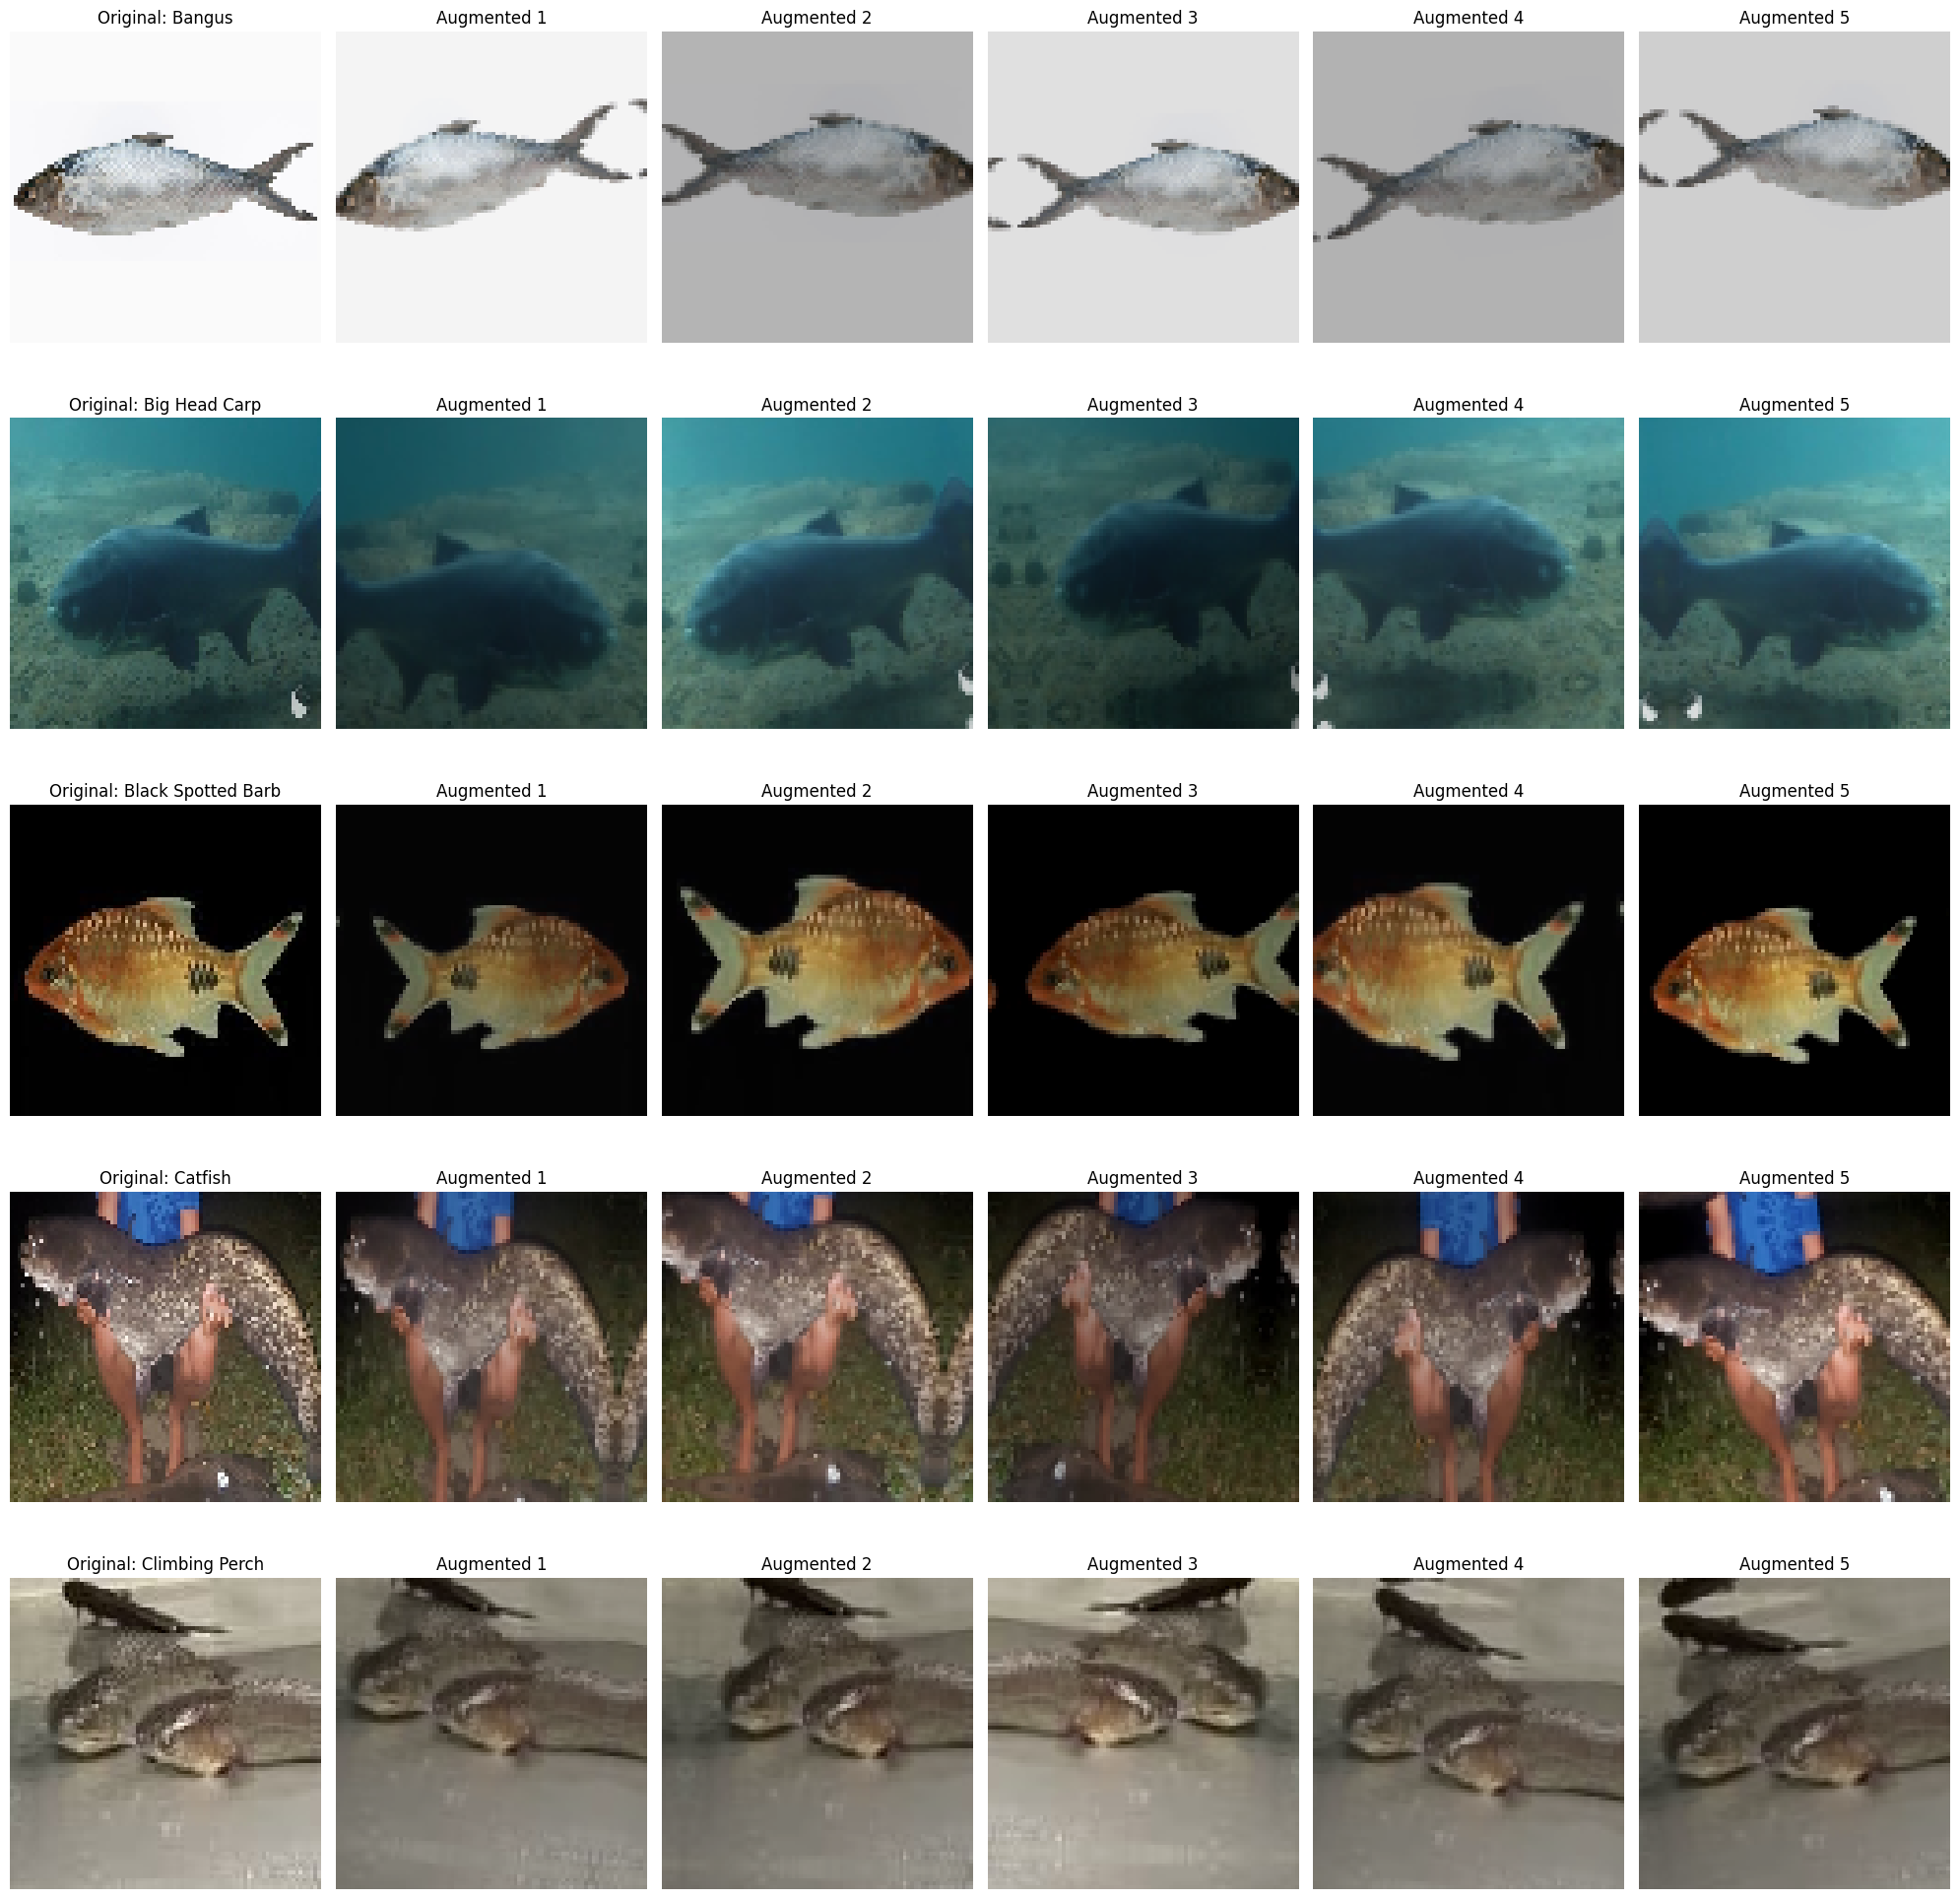

In [5]:
# Visualisasi beberapa contoh gambar dari dataset beserta augmentasi
def visualize_augmentation(datagen, dataset_path, class_names, num_samples=5):
    plt.figure(figsize=(20, 20))
    for i, fish_type in enumerate(class_names[:min(5, len(class_names))]):
        sample_dir = os.path.join(dataset_path, fish_type)
        if os.path.isdir(sample_dir):
            sample_files = os.listdir(sample_dir)[:1]  # Ambil 1 gambar per kelas
            for j, file in enumerate(sample_files):
                img_path = os.path.join(sample_dir, file)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)
                
                # Visualisasi gambar asli
                plt.subplot(len(class_names[:min(5, len(class_names))]), 
                            num_samples + 1, 
                            i * (num_samples + 1) + 1)
                plt.imshow(img)
                plt.title(f"Original: {fish_type}")
                plt.axis('off')
                
                # Visualisasi augmentasi
                augm_iterator = datagen.flow(x, batch_size=1)
                for k in range(num_samples):
                    augm_img = next(augm_iterator)[0]
                    plt.subplot(len(class_names[:min(5, len(class_names))]), 
                                num_samples + 1, 
                                i * (num_samples + 1) + k + 2)
                    plt.imshow(augm_img)
                    plt.title(f"Augmented {k+1}")
                    plt.axis('off')
                break
    
    plt.tight_layout()
    plt.savefig('data_augmentation_samples.png')
    plt.show()

print("Visualisasi augmentasi data...")
visualize_augmentation(train_datagen, train_path, class_names)

### 5. Menyiapkan Fungsi Evaluasi

In [6]:
def evaluate_metrics(y_true, y_pred, y_prob, num_classes=num_classes):
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc_score = roc_auc_score(y_true_one_hot, y_prob, average='macro', multi_class='ovr')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }

### 6. Menyiapkan Fungsi Visualisasi untuk Evaluasi

In [7]:
def visualize_results(history):
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Fungsi untuk menampilkan ROC curve
def visualize_roc_curve(y_true, y_scores):
    # Binarize the output
    n_classes = y_scores.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for a specific class (e.g., class 1)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr[1], tpr[1], label=f'ROC curve (area = {roc_auc[1]:.2f})')  # Example: Plotting for class 1
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10)) # Increase figure size
    plt.matshow(cm, cmap='Blues', fignum=1)
    plt.colorbar()
    plt.title('Confusion Matrix')
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
            
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(num_classes), class_names, rotation=90, fontsize=8) # Rotate x-axis labels
    plt.yticks(range(num_classes), class_names, fontsize=8) # Adjust y-axis label font size
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


## B. CNN Klasifikasi Ikan Dengan Tensorflow

### 1. Penyusunan Model Neural Network


In [8]:
# Membuat model CNN
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    # Inisialisasi model
    model = Sequential([
        # Input Layer
        Input(shape=input_shape),

        # Blok Konvolusional 1
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusional 2
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusional 3
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Inisialisasi model
model_cnn = create_cnn_model()

### 2. Kompilasi Model

In [9]:
# Kompilasi model
model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# 
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 84, 84, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 84, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 84, 84, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 84, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,274,655 (54.45 MB)

 Trainable params: 14,271,839 (54.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

### 3. Pelatihan Model

In [10]:
# Callbacks untuk optimasi training
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_regularized_model.keras', save_best_only=True)
]

# Menghitung steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

# Training model
print("Melatih model CNN...")
history = model_cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    batch_size=BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Melatih model CNN...
Epoch 1/100


I0000 00:00:1746077771.137469  117675 service.cc:152] XLA service 0x7f5b4c0147b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746077771.137537  117675 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-05-01 12:36:11.207198: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746077771.640585  117675 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-01 12:36:12.362221: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[32,64,84,84]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,84,84]{3,2,1,0} %bitcast.16259, f32[64,3,3,3]{3,2,1,0} %bitcast.16266, f32[64]{0} %bitcast.17915), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target=

226/276 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.1191 - loss: 3.9890

2025-05-01 12:36:48.181956: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.20 = (f32[1,128,42,42]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,42,42]{3,2,1,0} %bitcast.18480, f32[128,64,3,3]{3,2,1,0} %bitcast.16578, f32[128]{0} %bitcast.18540), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_2_1/convolution" source_file="/home/husain/dlvenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-01 12:36:48.290361: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted 

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1264 - loss: 3.9389

2025-05-01 12:36:58.602311: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[32,64,84,84]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,84,84]{3,2,1,0} %bitcast.938, f32[64,3,3,3]{3,2,1,0} %bitcast.945, f32[64]{0} %bitcast.947), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/husain/dlvenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-01 12:36:58.701660: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially

276/276 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.1265 - loss: 3.9379 - val_accuracy: 0.1243 - val_loss: 4.1337 - learning_rate: 0.0010
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - accuracy: 0.2418 - loss: 3.1419 - val_accuracy: 0.3799 - val_loss: 2.4628 - learning_rate: 0.0010
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 122ms/step - accuracy: 0.3237 - loss: 2.7502 - val_accuracy: 0.3533 - val_loss: 2.6870 - learning_rate: 0.0010
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - accuracy: 0.3780 - loss: 2.4897 - val_accuracy: 0.3221 - val_loss: 3.0863 - learning_rate: 0.0010
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - accuracy: 0.4310 - loss: 2.3305 - val_accuracy: 0.4002 - val_loss: 2.5459 - learning_rate: 0.0010
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - accuracy: 0.4648 - loss: 2.2133 - val_accuracy: 0.1381 - val_loss: 3.9307 - learning_rate: 0.0010
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 127ms/step - accuracy: 0.4937 -

### 4. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [11]:
# Evaluasi model
test_loss, test_accuracy = model_cnn.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")

# Konversi dataset untuk evaluasi metrik lengkap
y_test = []
y_pred = []
y_pred_proba = []

# Menghitung prediksi untuk semua data uji
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    y_test.extend(np.argmax(y_batch, axis=1))
    y_pred_prob = model_cnn.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_pred_proba.extend(y_pred_prob)

# Mengonversi ke numpy array
y_test = np.array(y_test)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Menghitung metrik evaluasi
results = evaluate_metrics(y_test, y_pred, y_pred_proba)

# Output metrik evaluasi
print("Hasil evaluasi:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall: {results['recall']:.4f}")
print(f"F1 Score: {results['f1']:.4f}")
print(f"AUC: {results['auc']:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8961 - loss: 1.0749
Test accuracy: 0.9045
Hasil evaluasi:
Accuracy: 0.9045
Precision: 0.9183
Recall: 0.9045
F1 Score: 0.9063
AUC: 0.9951


### 5. Memvisualisasikan Prediksi dari model yang telah dilatih

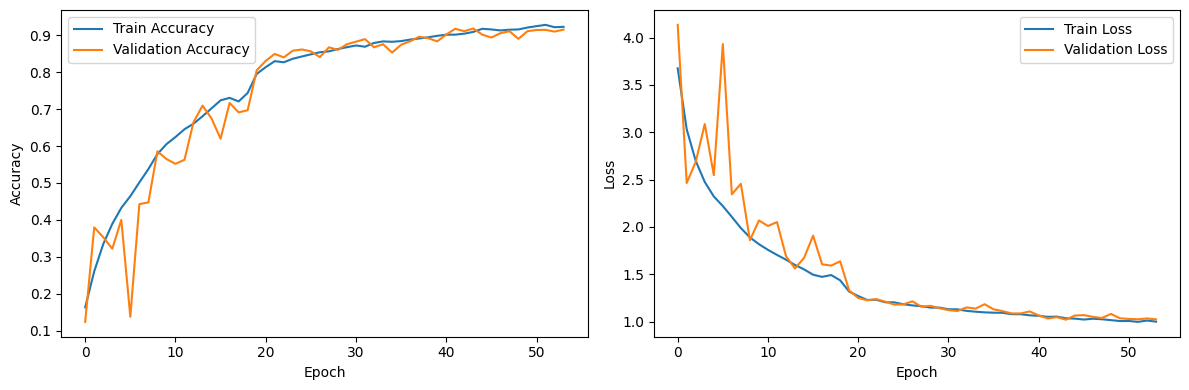

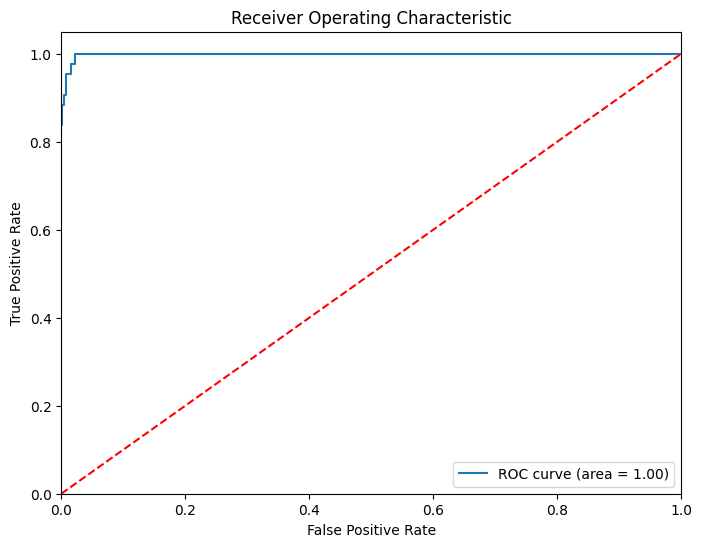

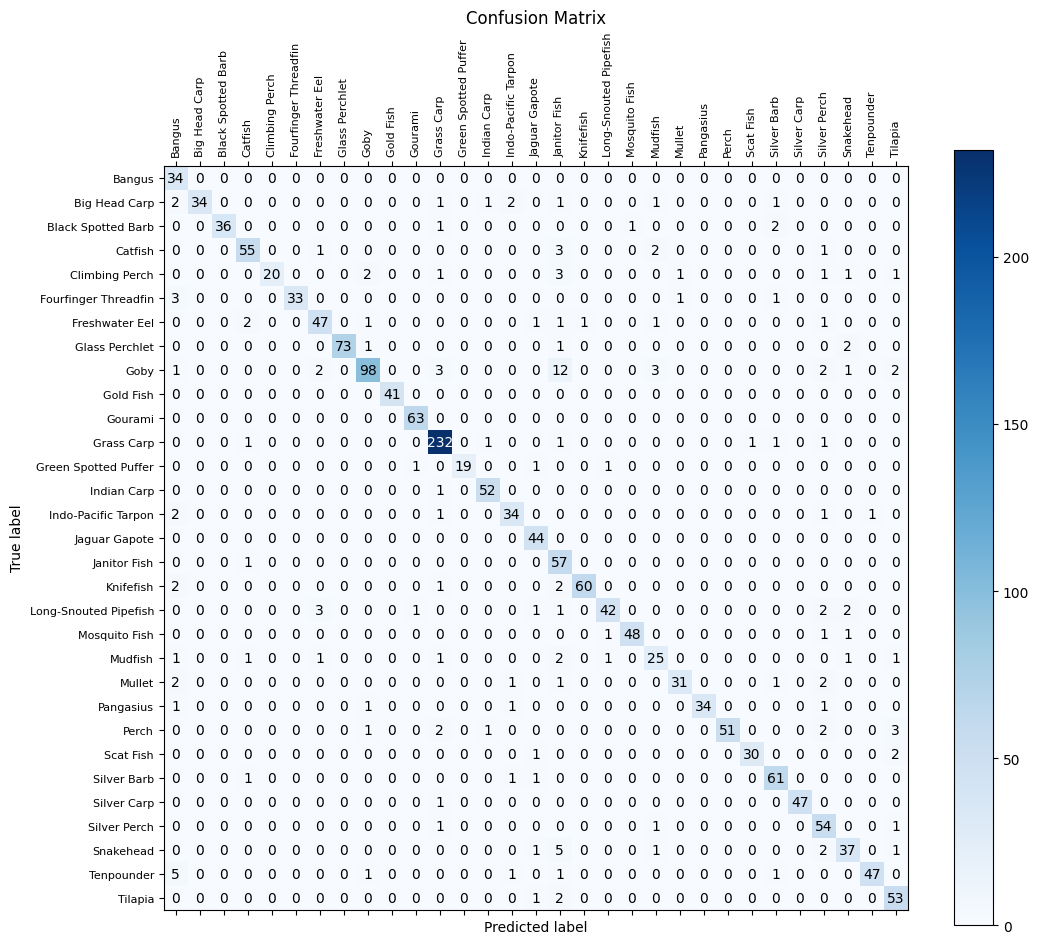

In [12]:
# Plot training history
visualize_results(history)

# Plot ROC curve (one vs rest untuk multi-kelas)
visualize_roc_curve(y_test, y_pred_proba)

# Plot confusion matrix
visualize_confusion_matrix(y_test, y_pred)

### 6. Menyimpan Model

In [13]:
# Menyimpan model
model_cnn.save('model_fish_classification.keras')
print("Model disimpan sebagai 'model_fish_classification.keras'")

Model disimpan sebagai 'model_fish_classification.keras'


# Penjelasan Teori dalam Pemodelan Klasifikasi Ikan Menggunakan Convolutional Neural Network

## Preprocessing dan Normalisasi Data

Satuan data pada cita merupakan suatu vektor dua dimensi yang merepresentasikan nilai $X$ dari piksel yang menjadi unit data terkecil dari suatu citra.

Operasi yang dilakukan pada data preprocessing antara lain:

### 1. Normalisasi (Rescaling)

Normalisasi nilai piksel dari [0, 255] menjadi [0, 1]:

$$ X_{normalized} = \frac{X}{255}$$

Tujuan normalisasi:

- Mempercepat konvergensi dalam gradient descent
- Mencegah dominasi fitur dengan skala besar
- Membuat gradien lebih stabil saat backpropagation

### 2. Data Augmentasi

Data augmentasi meningkatkan variasi dan jumlah data training dengan transformasi tertentu:

#### a. Rotasi:
$$ X_{rotated} = R_\theta \cdot X $$
Dimana $R_\theta$​ adalah matriks rotasi:

$$ R_\theta = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}$$

#### b. Shifting (Pergeseran):

$$ X_{shifted} = X + \Delta$$
Dimana $\Delta$ adalah vektor pergeseran pada sumbu x dan y.

#### c. Scaling (Zoom):

$$ X_{scaled} = S \cdot X $$
Dimana $S$ adalah matriks scaling:

$$ S = \begin{bmatrix} s_x & 0 \\ 0 & s_y \end{bmatrix} $$

#### d. Flipping (Pembalikan):

$$ X_{flipped} = S \cdot X $$
Untuk membalik secara horizontal:
$$ S = \begin{bmatrix} -1 & 0 \\ 0 & 1 \end{bmatrix} $$
Untuk membalik secara vertikal:
$$ S = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} $$

Flipping pada dasarnya adalah scaling dengan nilai scale negatif, menempatkan posisi piksel pada urutan terbalik secara global.

#### d. Shearing:

$$ X_{sheared} = \begin{bmatrix} 1 & \lambda \\ 0 & 1 \end{bmatrix} \cdot X$$
Dimana $\lambda$ adalah faktor shear.

Baik rotasi, shifting, scaling, dan shearing digunakan untuk menambah variasi karakteristik dari satu data, sehingga model dapat melakukan generalisasi dengan lebih baik dan mengurangi kemungkinan model untuk hanya menghafal dataset (yang berakibat pada overfittng).

## Penjelasan Dasar Teori dan Persamaan Matematika dalam Model CNN

### 1. Konvolusi (Convolution)
Dalam model CNN, operasi konvolusi adalah operasi dasar yang menjadi inti dari arsitektur. Secara matematis, konvolusi 2D dapat didefinisikan sebagai:

$$ h_{i,j,k} = ReLU\left(\sum_{a=0}^{f-1} \sum_{b=0}^{f-1} \sum_{c=0}^{C_{in}-1} W_{a,b,c,k} \cdot X_{i+a,j+b,c} + b_k\right) $$

Dimana:

$h_{i,j,k}$​ adalah output dari konvolusi pada posisi (i,j) untuk filter ke-k

$f$ adalah ukuran filter (misal 3×3)

$W_{a,b,c,k}$​ adalah bobot filter

$X_{i+a, j+b, c}$​ adalah aktivasi pada input atau layer sebelumnya

$C_{in}$​ adalah jumlah channel pada input atau layer sebelumnya

$b_k$​ adalah bias

Konvolusi bekerja dengan menggeser kernel di atas citra input, mengalikan nilai-nilai yang bertumpuk, dan menjumlahkan hasil untuk menghasilkan piksel output.

### 2. Aktivasi ReLU (Rectified Linear Unit)

Fungsi aktivasi ReLU yang digunakan dalam model didefinisikan sebagai:

$$f(x) = \max(0, x)$$

ReLU akan mengubah semua nilai negatif menjadi 0, sementara nilai positif tetap tidak berubah. Ini membantu model untuk belajar fungsi non-linear dan mengatasi masalah vanishing gradient.

### 3. Batch Normalization

Batch Normalization digunakan untuk menstabilkan dan mempercepat proses pembelajaran dengan menormalkan aktivasi di setiap lapisan. Rumus matematisnya adalah:

$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}​$$

$$y_i = \gamma \cdot \hat{x}_i + \beta$$

dimana:
- $x_i$ adalah input ke batch normalization
- $\mu_B$ adalah rata-rata mini-batch
- $\sigma_B^2$ adalah varians mini-batch
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\gamma$ dan $\beta$ adalah parameter yang dipelajari
- $y_i$ adalah output batch normalization

### 4. Max Pooling

Max Pooling digunakan untuk mengurangi dimensi spasial dengan memilih nilai maksimum dari setiap region. Secara matematis:

$$\text{MaxPool}(X)_{i,j} = \max_{m,n \in R_{i,j}} X_{m,n}​$$

dimana $R_{i,j}$ adalah region lokal yang berpusat di lokasi $(i,j)$.

### 5. Dropout

Dropout adalah teknik regularisasi yang mencegah overfitting dengan secara acak mematikan neuron selama training. Secara matematis, untuk setiap neuron:

$$\begin{cases}
x/p & \text{dengan probabilitas } p \\
0 & \text{dengan probabilitas } 1-p
\end{cases}$$

dimana $p$ adalah probabilitas mempertahankan (keep probability) dan $1-p$ adalah dropout rate.

### 6. Fully Connected Layer
Dalam CNN, lapisan fully-connected didefinisikan sebagai:

$$z = W \cdot a^{[-1]} + b$$
$$a = g(z)$$

dimana:
- $W$ adalah matriks bobot untuk lapisan fully connected
- $a^{[-1]}$ adalah aktivasi dari lapisan sebelum lapisan fully connected
- $b$ adalah vektor bias
- $g$ adalah fungsi aktivasi (seperti ReLU)
- $z$ adalah input terbobot
- $a$ adalah output lapisan fully connected

### 7. Fungsi Loss Cross-Entropy
Cross-entropy loss yang digunakan untuk klasifikasi multi-kelas didefinisikan sebagai:

$$L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(p_{i,c})$$

dimana:
- $N$ adalah jumlah sampel
- $C$ adalah jumlah kelas
- $y_{i,c}$ adalah indikator (0 atau 1) apakah kelas c adalah label yang benar untuk sampel i
- $p_{i,c}$ adalah probabilitas yang diprediksi bahwa sampel i adalah kelas c

### 8. Optimizer Adam
Adam (Adaptive Moment Estimation) adalah algoritma optimasi yang menggabungkan RMSprop dan momentum. Adam memperbarui bobot menggunakan rangkaian rumus:

Update momentum:
$$m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t$$

Update velocity:
$$v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2$$

Koreksi bias:
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$

Update parameter:
$$\theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

dimana:
- $g_t$ adalah gradien pada waktu t
- $m_t$ dan $v_t$ adalah estimasi momen pertama dan kedua
- $\hat{m}_t$ dan $\hat{v}_t$ adalah estimasi momen yang dikoreksi
- $\alpha$ adalah learning rate
- $\beta_1$ dan $\beta_2$ adalah exponential decay rates
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\theta_t$ adalah parameter yang diperbarui

### 9. Softmax
Fungsi softmax digunakan pada output layer untuk mengubah logits menjadi probabilitas yang berjumlah 1:

$$\text{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{k} e^{x_j}}$$

dimana $x_i$ adalah nilai logit untuk kelas i dan k adalah jumlah kelas.

### 10. Learning Rate Decay (ReduceLROnPlateau)

Mengurangi learning rate ketika metrik pembelajaran stagnan:
$$ \alpha_{\text{new}} = \alpha_{\text{old}} \times \text{factor}$$
Dimana factor biasanya 0.1

## Penjelasan Metrik Evaluasi:
### Akurasi

$$ \text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}} $$

Menunjukkan seberapa sering model memprediksi dengan benar.


### Presisi

$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $$

Menunjukkan seberapa andal model memprediksi nilai positif secara benar (dibandingkan dengan positif palsu).


### Recall (Sensitivity)

$$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$

Menunjukkan seberapa baik model menangkap kelas positif dengan benar (dengan memperhatikan nilai positif yang terprediksi negatif atau false negative).


### F1-Score

$$ \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

Rata-rata harmonik antara presisi dan recall.


### ROC (Receiver Operating Characteristic) Curve

ROC Curve memplot hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR):

$$ \text{True Positive Rate (TPR)} = \text{Recall} $$

$$ \text{False Positive Rate (FPR)} = \frac{\text{False Positives}}{ \text{False Positives} + \text{True Negatives}} $$


### AUC-ROC

$$ AUC = \int_{0}^{1} TPR(x) \, dx $$

AUC (Area Under Curve) adalah area di bawah kurva ROC (Receiver Operating Characteristic)

## Analisis Matriks Evaluasi Terbaik
Untuk kasus klasifikasi gambar ikan, matriks evaluasi terbaik tergantung pada kebutuhan spesifik, namun secara umum:

*F1-Score merupakan matriks yang sangat informatif*, karena:

- Menyeimbangkan precision (yang fokus terhadap false positive) dan recall (fokus terhadap false negative).
- Sangat berguna jika dataset tidak seimbang antar kelas
Memberikan gambaran keseluruhan performa model


*AUC-ROC juga sangat penting*, karena:

- Mengukur kemampuan model membedakan antar kelas
Tidak terpengaruh oleh threshold klasifikasi
Ideal untuk perbandingan model secara keseluruhan


Confusion Matrix memberikan insight paling detail tentang:

- Jenis kesalahan yang dilakukan model
- Kelas mana yang sering salah diklasifikasikan
- Pola kesalahan yang mungkin menunjukkan kelemahan model

Akurasi, meskipun mudah diinterpretasi, bisa menyesatkan jika dataset tidak seimbang. Oleh karena itu, evaluasi terbaik adalah kombinasi dari beberapa matriks, dengan penekanan pada F1-Score untuk keseimbangan dan confusion matrix untuk analisis detail.